# StarSolo vs CellRanger matrices

Here we will attempt to find differences between the count matrix generated by STARsolo and CellRanger on the same FASTQ dataset.

## What we have

 * 1 Case matrix from CellRanger 
 * 1 Control matrix from CellRanger
 * 1 Control matrix from STARSolo
 
 
## Other info

The FASTQ Files with labels `41737` and `41738` relate to matrices `CTR` and `siN6amt1` respectively, given to us by Roland, [info](https://usegalaxy.eu/datasets/11ac94870d0bb33a85dfea052f40d61a/display/?preview=True)

### STARSolo matrix Generation

The STARSolo data was generated using FASTQ data `41737_R1.fastq.gz` (barcodes+UMI) and `41737_R2.fastq.gz` (sequences), which generated the reads in `outputs/V2matrix.mtx`. The process is documented in the *Snakefile* in this repo. The genome version is an ensembl Hg38r99 which was mapped to produced an SAindex file and the reads were demultiplexed using the Chromiumv2 protocol (as discovered due to the 26bp not 28bp (v3) in the barcodes) with the `737K-august-2016.txt` barcodes.

# Issues

## Different STAR indices 

In order to do a comparative analysis between the two matrices, it would be prudent to use the same STAR index. **However,** each version of STARSolo generates indices that are incompatible with the previous, meaning that we *cannot* measure the effect that using two different STAR indices will have in matrix generation:

> EXITING because of FATAL ERROR: Genome version: 20201 is INCOMPATIBLE with running STAR version: 2.7.1a  
> SOLUTION: please re-generate genome from scratch with running version of STAR, or with version: 2.7.1a

## Different Output matrices

When we look at the CTR matrix given to us by Roland, below, we see that we are expecting 3079 cells. Instead we see 737,000 cells which is the entire list of barcodes. CellRanger performs some quality filtering measures that reduces the 737,000 cells into 3079 quality cells.

This discrepancy is mentioned on the 10X site [here](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/matrices) where they tell us that:

| Type | Description |
|------|-------------|
| Unfiltered feature-barcode matrix | Contains every barcode from fixed list of known-good barcode sequences. This includes background and cell associated barcodes |
| Filtered feature-barcode matrix | Contains only detected cellular barcodes. |

The site is unhelpful in telling us *how* the filtered matrix is generated, only that it is. 

It looks like we are getting the former, rather than the latter of these matrices. I opened an [issue](https://github.com/alexdobin/STAR/issues/644) on the topic with the hope that Alex Dobin would elucidate the default filtering parameters, or else implement it into one the STAR flags.


### Subselecting barcodes?

At first I was under the impression that they were further subselecting barcodes from the 737K list based on laning information, where the [laning](https://usegalaxy.eu/datasets/11ac94870d0bb33a85dfea052f40d61a/display/?preview=True) specifies that the controls used Lane5. However I have not been able to unearth any subselecting based on Lane info in either the source or the online documentation.

### Can the 3079 Cells be found via filtering?

By looking into the source at cellranger-cs/2.1.1/lib/python/cellranger/stats.py, we can see several ways that 10X might be doing their filtering:
 1. Filter by order of magnitude from top cell
 1. Filter by some user cutoff threshold

Below I tried to get the number of cells down from 737K to 3K, which I did manage to do via progressive filters:

| Filter | Num. Cells |
|:-------|:----------:|
| 1. None | 737K |
| 2. min_genes >= 200, min_cells >= 3 | 696K |
| 3. num_genes < 8000, mito_perc < 0.1 | 680K |
| 4. 2000 < num_counts < 80000, mito_perc < 0.07 | 4K |

So it seemed that most of the cells were extremely low quality, but we would still need to constrain the filter window to get the 3079 cells observed previously.

## Is the clustering similar?

We shall see -- I am now performing a side-by-side preprocessing of the CTR and V2 matrix and then will check out the clustering

## Other things to try

 * See if we can replicate some of the filtering procedures used by CellRanger count?



# Initial Stab

Load the three matrices

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd

In [75]:
v2mat = sc.read_10x_mtx('./outputs/V2/', var_names='gene_symbols', cache=True)

... reading from cache file cache/outputs-V2-matrix.h5ad


In [8]:
sinmat = sc.read_10x_mtx('/extra/schule/siN6amt1', var_names='gene_symbols', cache=True)

In [40]:
v2mat

AnnData object with n_obs × n_vars = 737280 × 58884 
    var: 'gene_ids'

### Look for FASN expression

In [46]:
v2mat[:,v2mat.var.index.isin(["FASN","N6AMT1"])]

View of AnnData object with n_obs × n_vars = 737280 × 2 
    var: 'gene_ids'

### Verifying the barcodes

737,280 cells detected in the V2 matrix!?!? That's insane. 

In [52]:
%%bash 
cat outputs/V2/barcodes.tsv | wc -l

737280


Yep, that's really a lot. We should be seeing far far less. What is the reason for this? We used the barcodes file given to us by CellRanger....

In [55]:
%%bash
cat sources/737K-august-2016.txt | wc -l
diff -b sources/737K-august-2016.txt outputs/V2/barcodes.tsv

737280


Yep these are definitely the same file. Okay, so it looks like some filtering needs to be performed to discard cells with zero counts. The parameters given by STARSolo don't seem to hint towards any filtering parameters that could be used.

In [57]:
%%bash
cat outputs/V2/Gene.stats

                                        Barcodes:
                                       nNinBarcode         917177
                                   nUMIhomopolymer         356422
                                          nTooMany              0
                                          nNoMatch        8862764
                                              Gene:
                                         nUnmapped         400554
                                        nNoFeature       78297436
                                     nAmbigFeature       44414730
                             nAmbigFeatureMultimap       34990552
                                          nTooMany          91680
                                     nNoExactMatch          17511
                                       nExactMatch      230176140
                                            nMatch      235846506
                                     nCellBarcodes         561075
                                        

From the stats file we can see that there are 561k of the 787k cells were detected, which seems good.

### Number of non-zero barcodes?

In [76]:
v2mat.var_names_make_unique()

In [77]:
v2mat

AnnData object with n_obs × n_vars = 737280 × 58884 
    var: 'gene_ids'

In [67]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.1 anndata==0.6.19 numpy==1.16.3 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


filtered out 176205 cells that have less than 1 counts


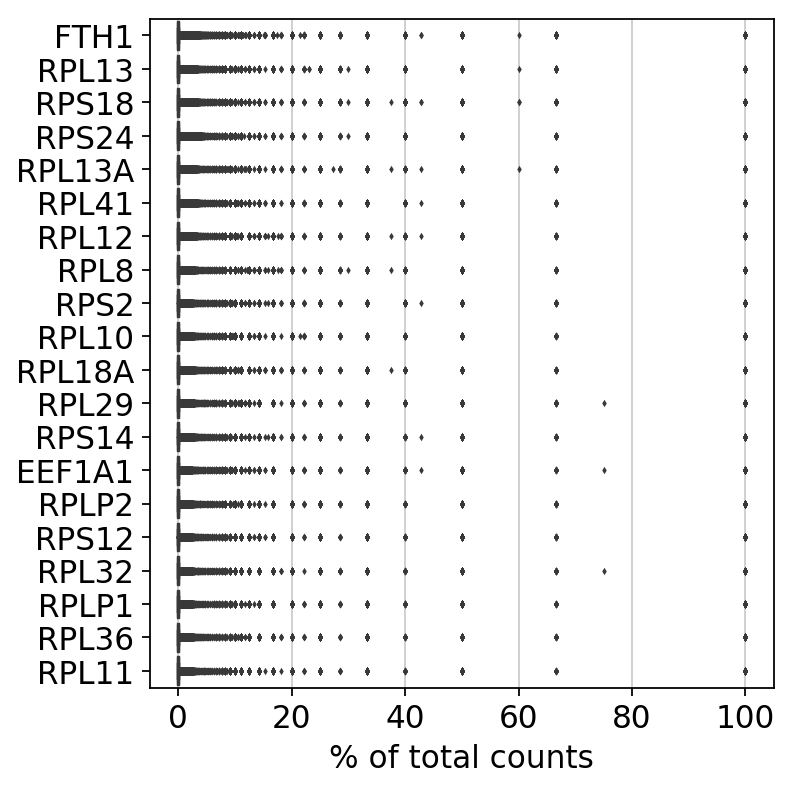

In [78]:
sc.pl.highest_expr_genes(v2mat, n_top=20)

In [80]:
sc.pp.filter_cells(v2mat, min_genes=200)
sc.pp.filter_genes(v2mat, min_cells=3)

filtered out 667602 cells that have less than 200 genes expressed
filtered out 33787 genes that are detected in less than 3 cells


In [82]:
v2mat

AnnData object with n_obs × n_vars = 69678 × 25097 
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

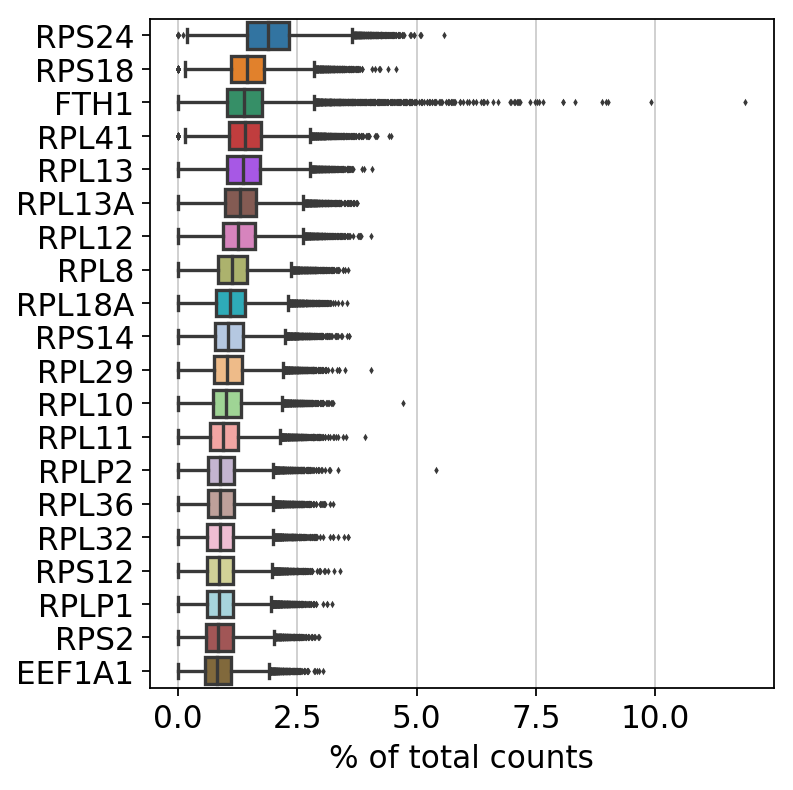

In [81]:
sc.pl.highest_expr_genes(v2mat, n_top=20)

Let's compare our above expression plot to the ctr matrix using the same filtering parameters:

In [84]:
ctrmat = sc.read_10x_mtx('/extra/schule/ctr', var_names='gene_symbols', cache=True)
ctrmat.var_names_make_unique()
sc.pp.filter_cells(ctrmat, min_genes=200)
sc.pp.filter_genes(ctrmat, min_cells=3)

... reading from cache file cache/extra-schule-ctr-matrix.h5ad
filtered out 15054 genes that are detected in less than 3 cells


In [85]:
ctrmat

AnnData object with n_obs × n_vars = 3709 × 18640 
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

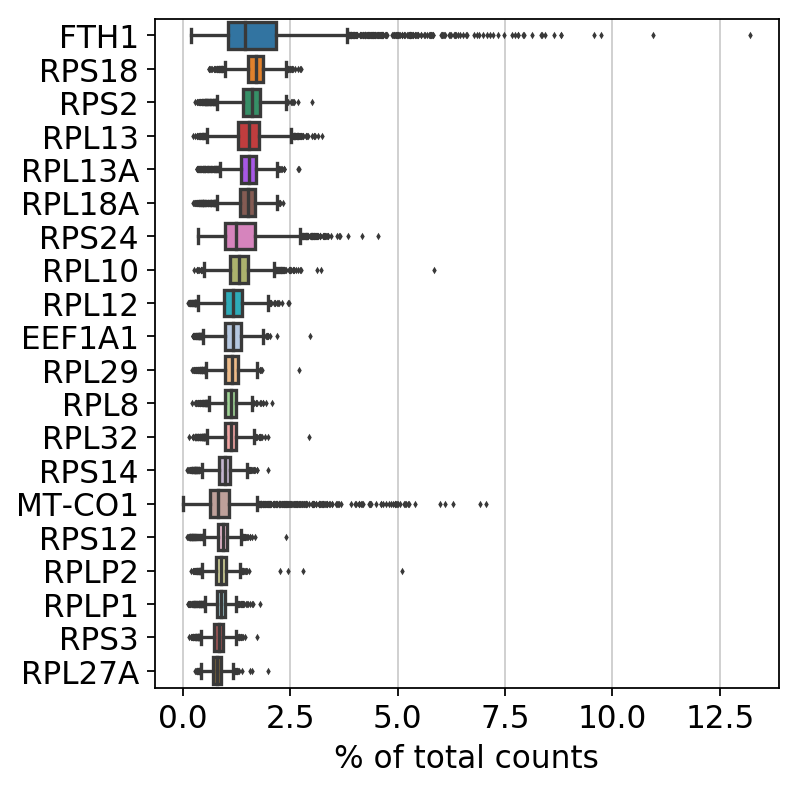

In [86]:
sc.pl.highest_expr_genes(ctrmat, n_top=20)

We are seeing a lot of differences already, where FTH1 was the highest most DE gene in the analysis and in the V2 matrix it was RPS24

We shall instead proceed with the filtering approach and see if we can replicate some of the filtering procedures used by CellRanger count. But first we will try to obtain the same clustering as the CTR matrix and see if we can get rid of a batch effect

# Reproducing 3K cells using progressive filtering on the V2 matrix

In [129]:
mito_genes = v2mat.var_names.str.startswith('MT-')
v2mat.obs['percent_mito'] = np.sum(v2mat[:, mito_genes].X, axis=1).A1 / np.sum(v2mat.X, axis=1).A1
v2mat.obs['n_counts'] = v2mat.X.sum(axis=1).A1

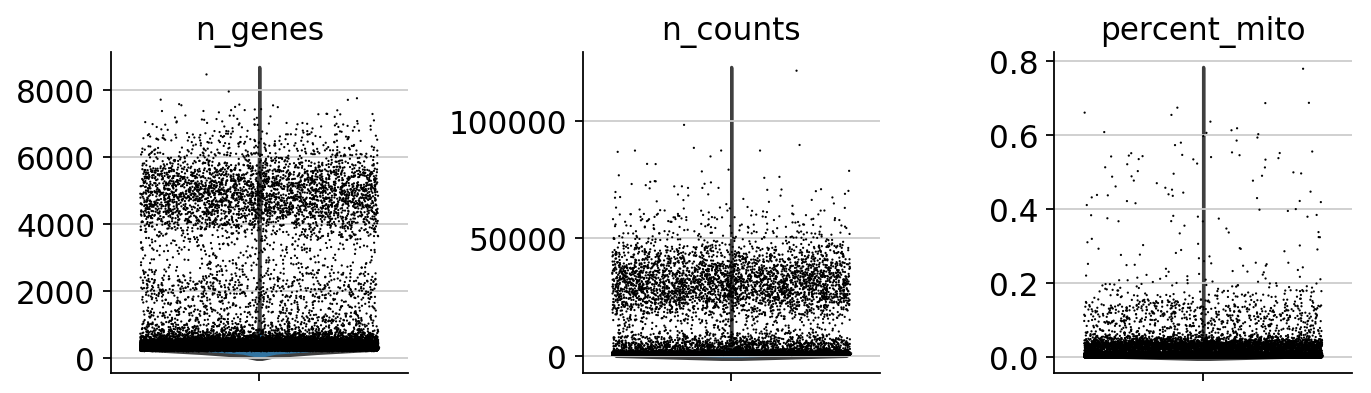

In [130]:
sc.pl.violin(v2mat, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

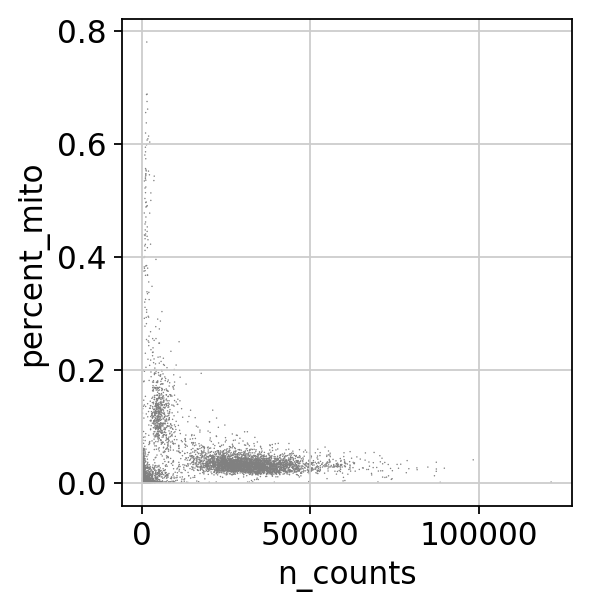

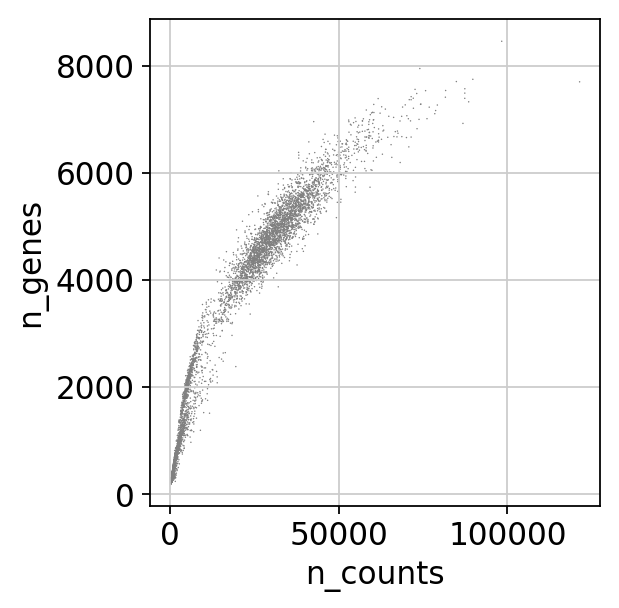

In [131]:
sc.pl.scatter(v2mat, x='n_counts', y='percent_mito')
sc.pl.scatter(v2mat, x='n_counts', y='n_genes')

In [132]:
v2mat

AnnData object with n_obs × n_vars = 69678 × 25097 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [92]:
v2mat = v2mat[v2mat.obs['n_genes'] < 8000, :]
v2mat = v2mat[v2mat.obs['percent_mito'] < 0.1, :]

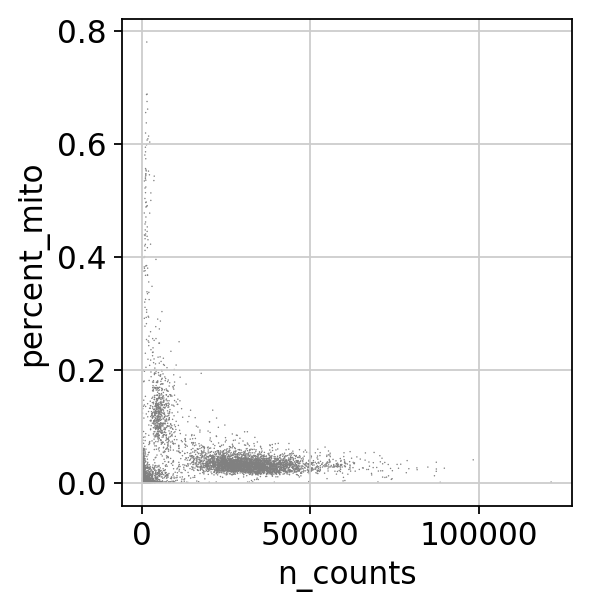

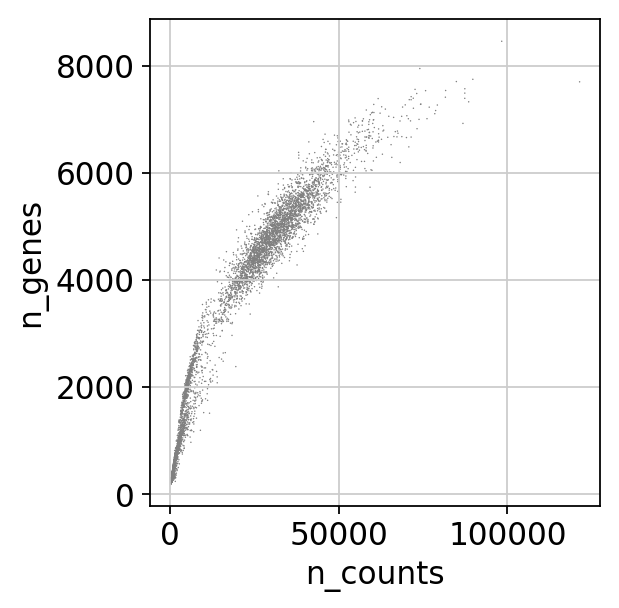

In [133]:
sc.pl.scatter(v2mat, x='n_counts', y='percent_mito')
sc.pl.scatter(v2mat, x='n_counts', y='n_genes')

In [134]:
v2mat

AnnData object with n_obs × n_vars = 69678 × 25097 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

Still a ton of cells within the acceptable upper-limits. Let's see if we can apply some lower-limits and see what is what

In [104]:
v2mat = v2mat[v2mat.obs['n_counts'] > 2000, :]
v2mat = v2mat[v2mat.obs['n_counts'] < 80000, :]
v2mat = v2mat[v2mat.obs['percent_mito'] < 0.07, :]

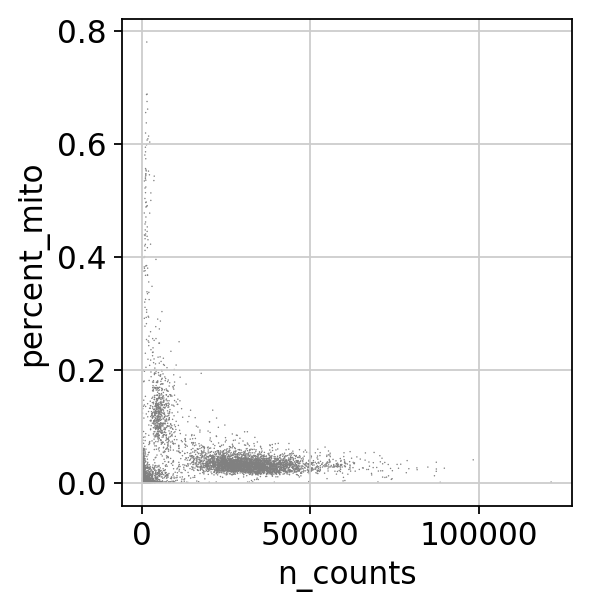

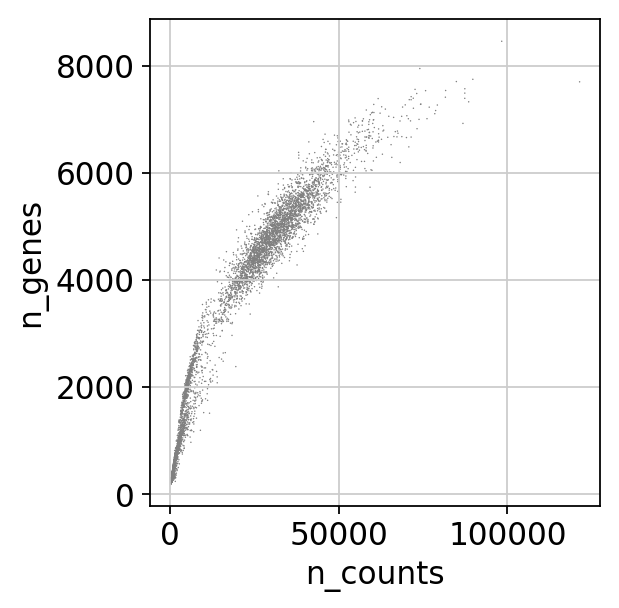

In [135]:
sc.pl.scatter(v2mat, x='n_counts', y='percent_mito')
sc.pl.scatter(v2mat, x='n_counts', y='n_genes')

In [137]:
v2mat

AnnData object with n_obs × n_vars = 69678 × 25097 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [138]:
sc.pp.normalize_per_cell(v2mat, counts_per_cell_after=3e4)

In [139]:
sc.pp.log1p(v2mat)

In [140]:
v2mat.raw = v2mat

In [141]:
sc.pp.highly_variable_genes(v2mat, min_mean=0.0125, max_mean=3, min_disp=0.5)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


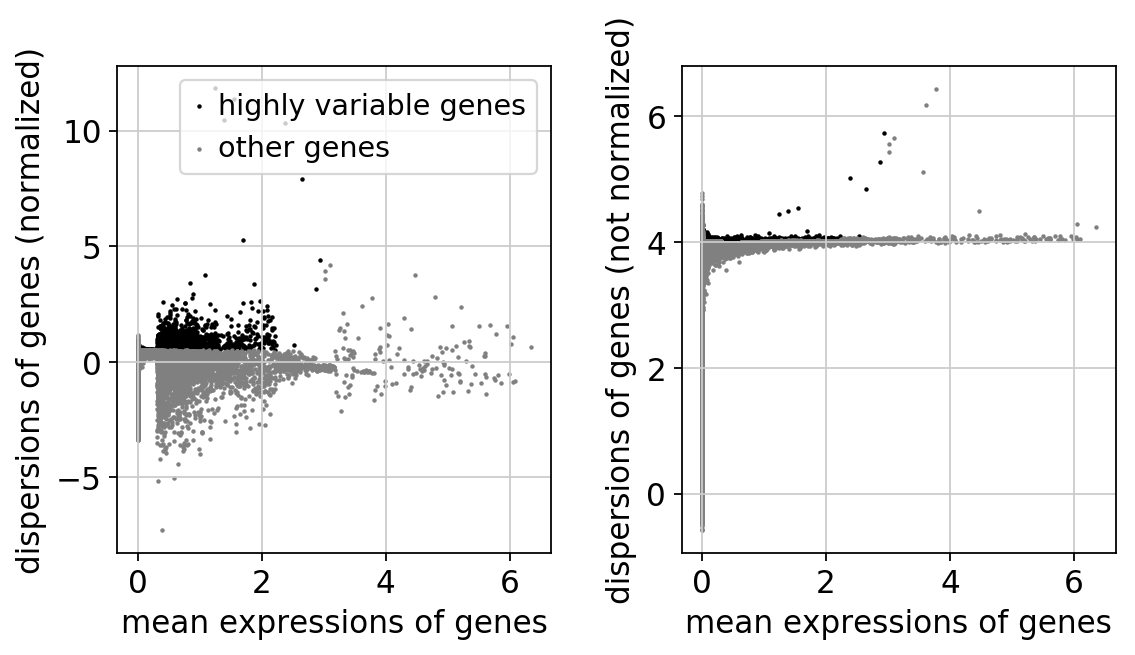

In [142]:
sc.pl.highly_variable_genes(v2mat)

In [143]:
v2mat = v2mat[:, v2mat.var['highly_variable']]

In [144]:
v2mat

View of AnnData object with n_obs × n_vars = 69678 × 2094 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [145]:
sc.pp.scale(v2mat, max_value=10)

In [146]:
sc.tl.pca(v2mat, svd_solver='arpack')

computing PCA on highly variable genes


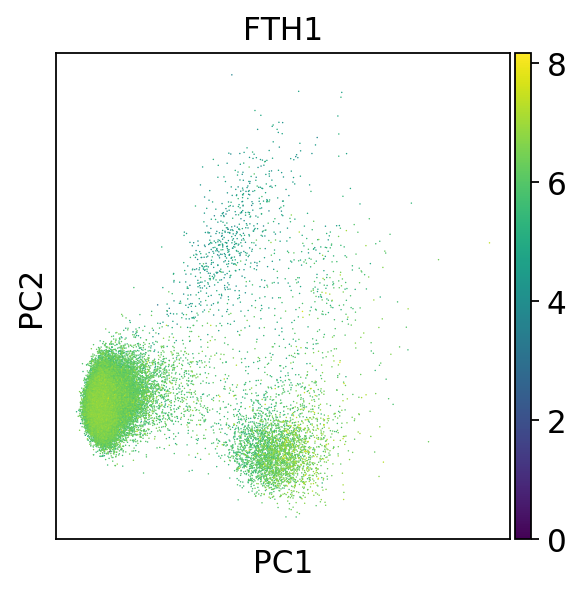

In [147]:
sc.pl.pca(v2mat, color='FTH1')

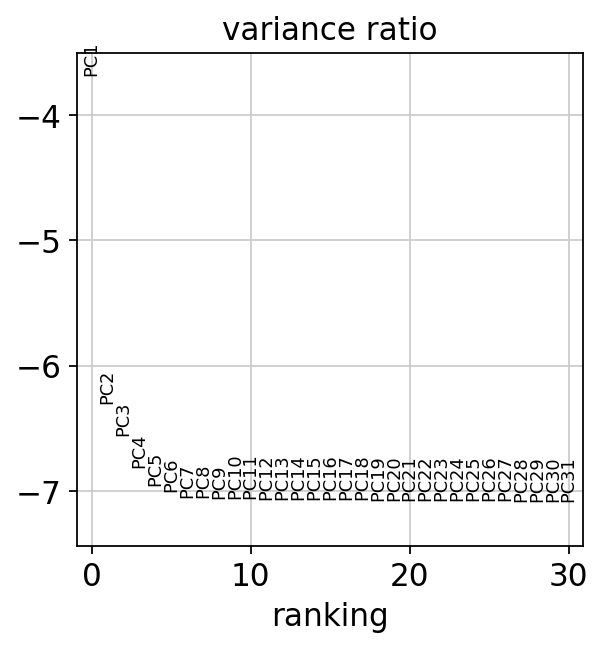

In [148]:
sc.pl.pca_variance_ratio(v2mat, log=True)

In [119]:
sc.pp.neighbors(v2mat, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:09.74) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [120]:
sc.tl.umap(v2mat)

computing UMAP
    finished (0:00:14.87) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [121]:
sc.tl.louvain(v2mat)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.43) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


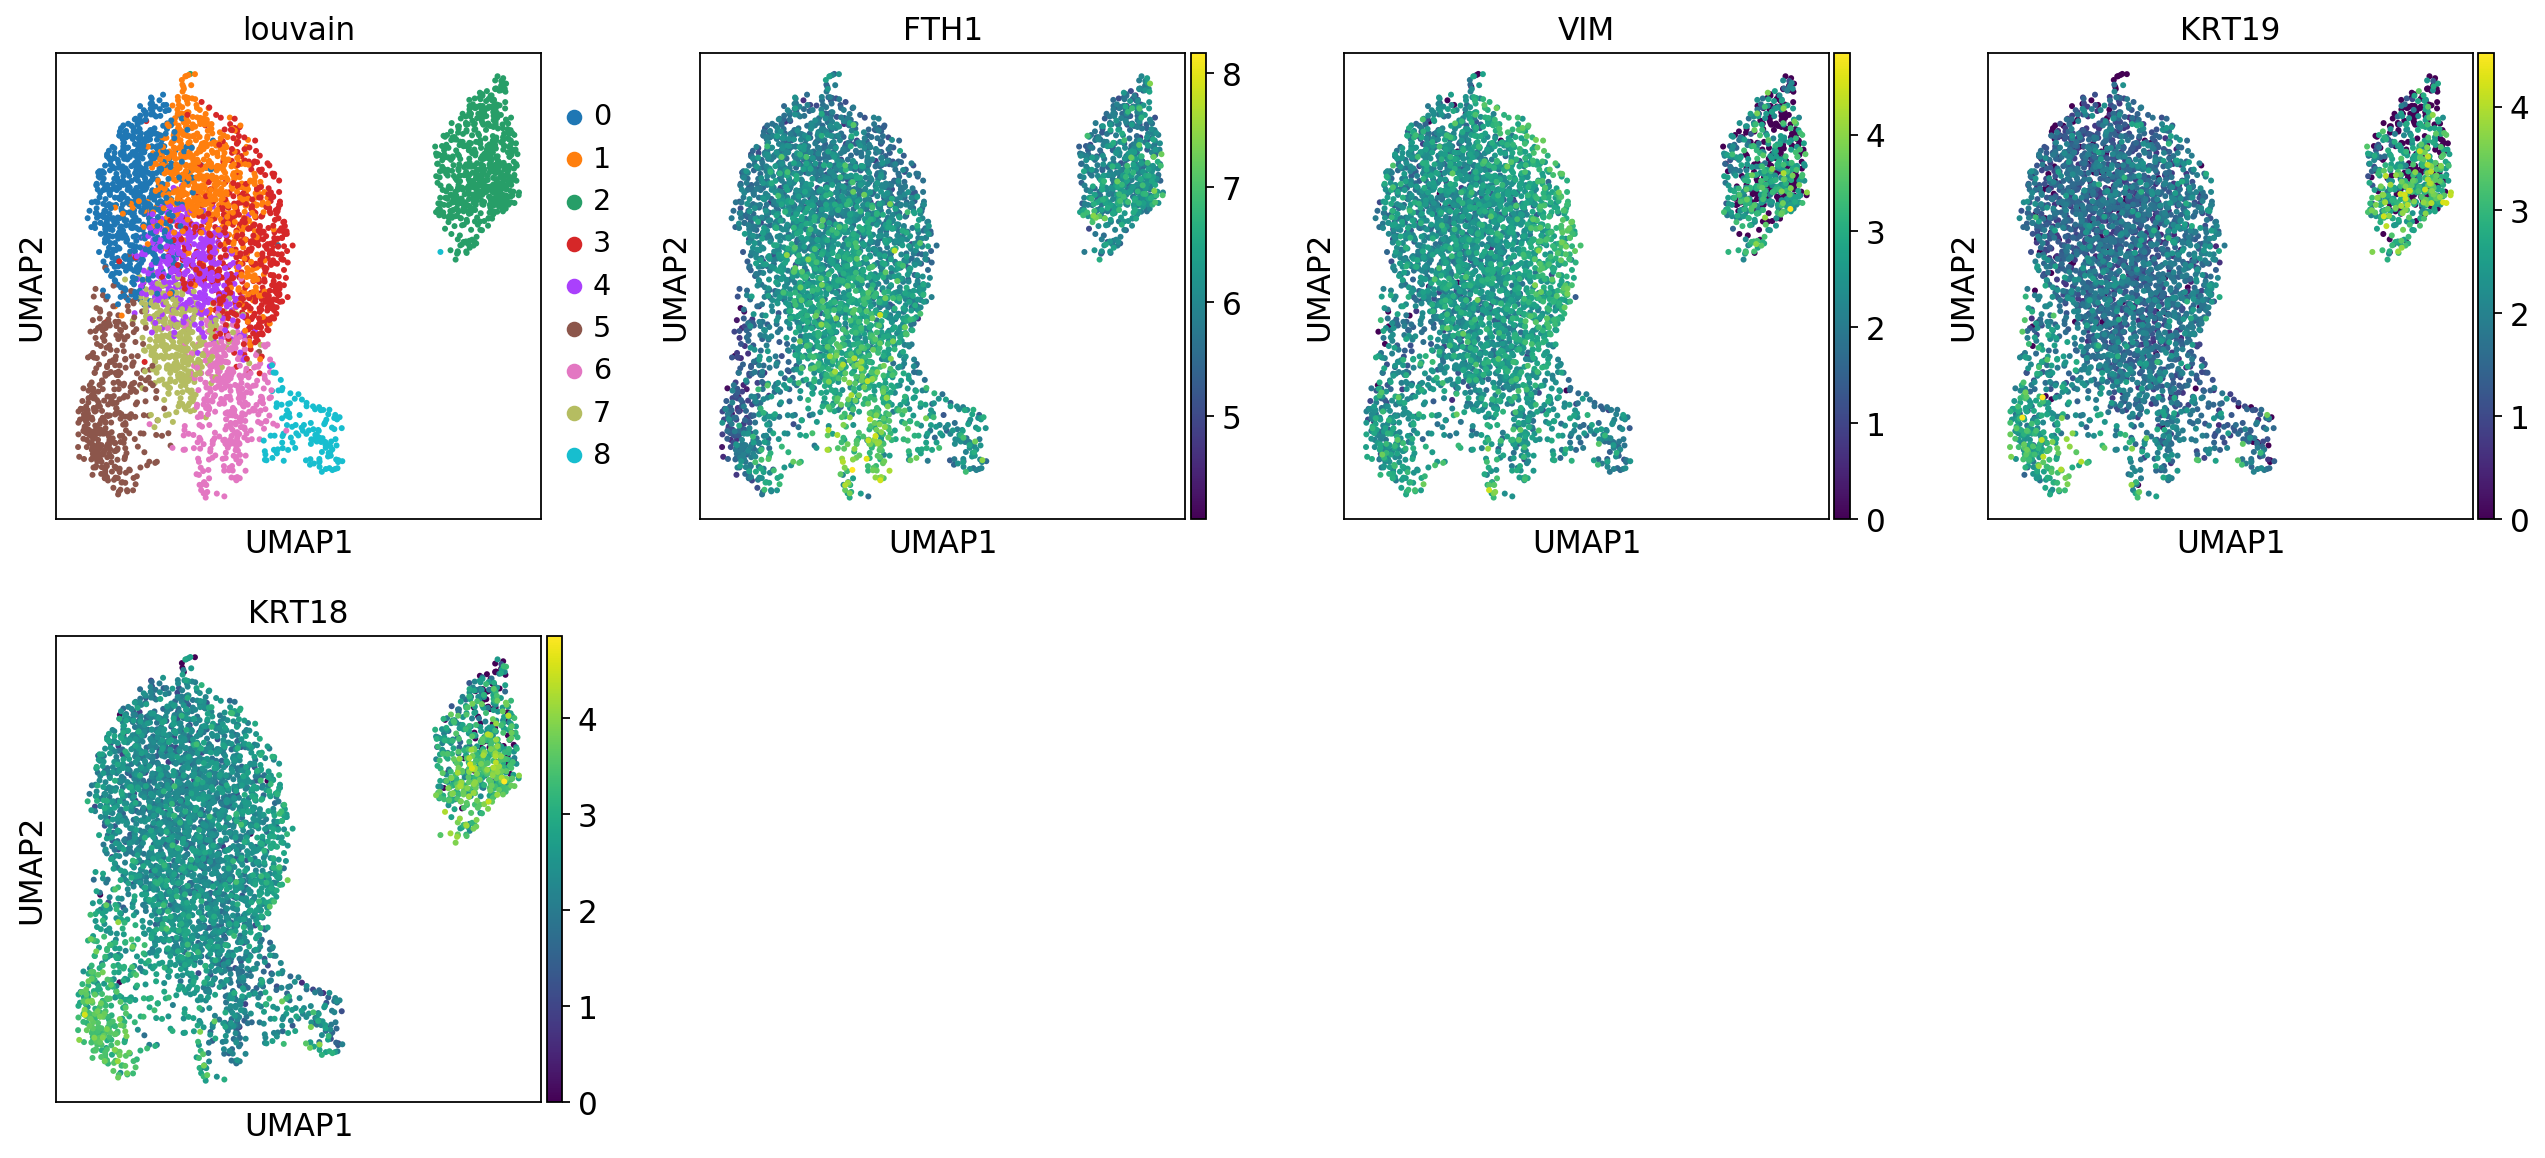

In [124]:
sc.pl.umap(v2mat, color=['louvain', 'FTH1', 'VIM', 'KRT19', 'KRT18'])

This is really nice clustering. Let's see what that disjointed cluster 2 is made of.

ranking genes
    finished (0:00:05.57) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


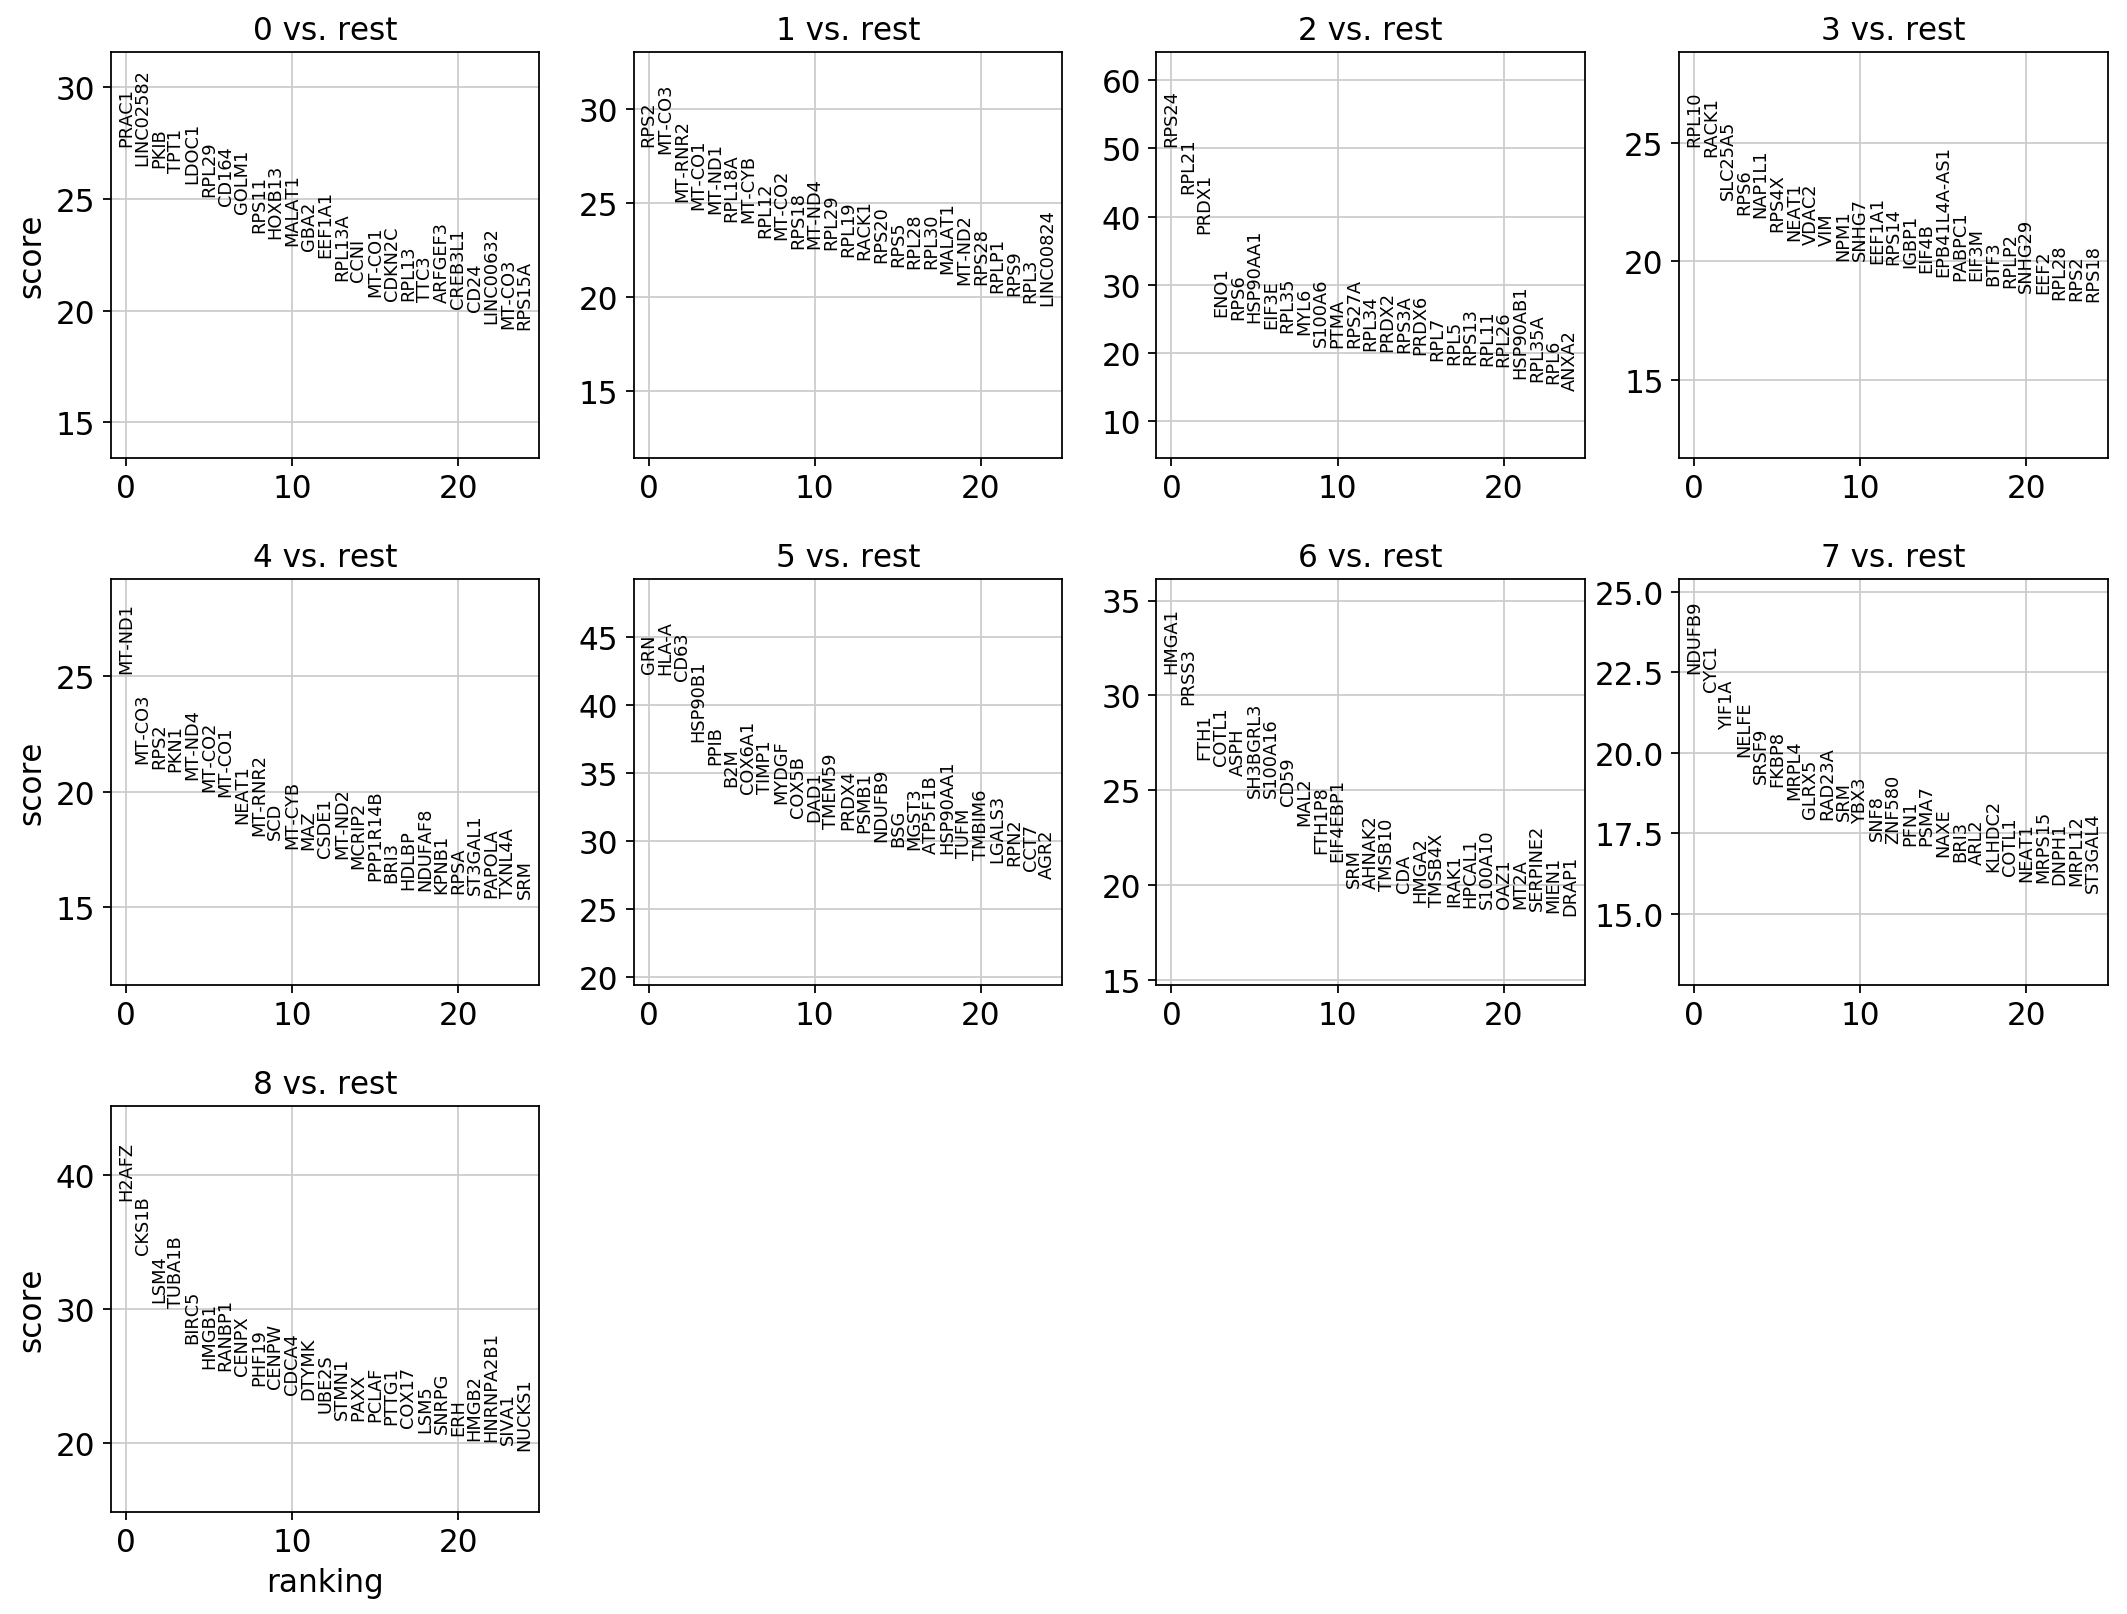

In [123]:
sc.tl.rank_genes_groups(v2mat, 'louvain', method='t-test')
sc.pl.rank_genes_groups(v2mat, n_genes=25, sharey=False)

# A side by side comparison of CTR and V2 matrix

Here we will apply the same methods and filters to both matrices to see if we can get the same level of  clustering.

In [178]:


def DoEverything(mat):
    # Compute Metrics
    mito_genes = mat.var_names.str.startswith('MT-')
    mat.obs['percent_mito'] = np.sum(mat[:, mito_genes].X, axis=1).A1 / np.sum(mat.X, axis=1).A1
    mat.obs['n_counts'] = mat.X.sum(axis=1).A1
    
    # Filter
    print("Cells= %d, Genes= %d" % (mat.n_obs,mat.n_vars))
    sc.pp.filter_cells(mat, min_genes=200)
    sc.pp.filter_genes(mat, min_cells=3)
    print("Cells= %d, Genes= %d" % (mat.n_obs,mat.n_vars))
    mat = mat[mat.obs['n_genes'] < 8000, :]
    print("Cells= %d, Genes= %d" % (mat.n_obs,mat.n_vars))
    mat = mat[mat.obs['percent_mito'] < 0.07, :]
    print("Cells= %d, Genes= %d" % (mat.n_obs,mat.n_vars))
    mat = mat[mat.obs['n_counts'] > 2000, :]
    print("Cells= %d, Genes= %d" % (mat.n_obs,mat.n_vars))
    mat = mat[mat.obs['n_counts'] < 80000, :]
    print("Cells= %d, Genes= %d" % (mat.n_obs,mat.n_vars))

    # Feature Selection + Normalise/Scale
    sc.pp.normalize_per_cell(mat, counts_per_cell_after=3e4)
    sc.pp.log1p(mat)
    mat.raw = mat
    sc.pp.highly_variable_genes(mat, min_mean=0.0125, max_mean=3, min_disp=0.5)
    mat = mat[:, mat.var['highly_variable']]
    print("Cells= %d, Genes= %d" % (mat.n_obs,mat.n_vars))
    sc.pp.scale(mat, max_value=10)
    
    # Cluster
    sc.tl.pca(mat, svd_solver='arpack')
    sc.pp.neighbors(mat, n_neighbors=10, n_pcs=40)
    sc.tl.umap(mat)
    sc.tl.louvain(mat)
    sc.tl.rank_genes_groups(mat, 'louvain', method='t-test')
    return(mat)

In [179]:
v2mat = sc.read_10x_mtx('./outputs/V2/', var_names='gene_symbols', cache=True)

... reading from cache file cache/outputs-V2-matrix.h5ad


In [181]:
ctrmat = sc.read_10x_mtx('/extra/schule/ctr', var_names='gene_symbols', cache=True)

... reading from cache file cache/extra-schule-ctr-matrix.h5ad


In [183]:
v2mat = DoEverything(v2mat)

Cells= 69678, Genes= 25097
Cells= 69678, Genes= 25097
Cells= 69677, Genes= 25097
Cells= 68893, Genes= 25097
Cells= 4117, Genes= 25097
Cells= 4107, Genes= 25097
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Cells= 4107, Genes= 5548
computing PCA on highly variable genes
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:02.19) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:12.32) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.37) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
ranking genes
    finished (0:00:06.18) --> added to `.uns['rank_genes_groups']`
   

In [184]:
ctrmat = DoEverything(ctrmat)

Cells= 3709, Genes= 33694
filtered out 15054 genes that are detected in less than 3 cells
Cells= 3709, Genes= 18640
Cells= 3709, Genes= 18640
Cells= 3544, Genes= 18640
Cells= 3544, Genes= 18640
Cells= 3527, Genes= 18640
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Cells= 3527, Genes= 1917
computing PCA on highly variable genes
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:01.82) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:14.34) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.27) --> found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
ranking genes
    finis

In [192]:
print("[ v2] Cells= %d, Genes= %d" % (v2mat.n_obs, v2mat.n_vars))
print("[CTR] Cells= %d, Genes= %d" % (ctrmat.n_obs, ctrmat.n_vars))

[ v2] Cells= 4107, Genes= 5548
[CTR] Cells= 3527, Genes= 1917


Already we can see that the CTRmat has less highly variable genes than our V2 matrix....
Save everything and do an actual venn intersection of highly variable genes.

In [190]:
%%bash
mkdir savepoints

In [195]:
v2mat.write_h5ad("savepoints/v2mat.h5ad")
ctrmat.write_h5ad("savepoints/ctrmat.h5ad")

# Clustering examination

filtered out 2229 cells that have less than 1 counts


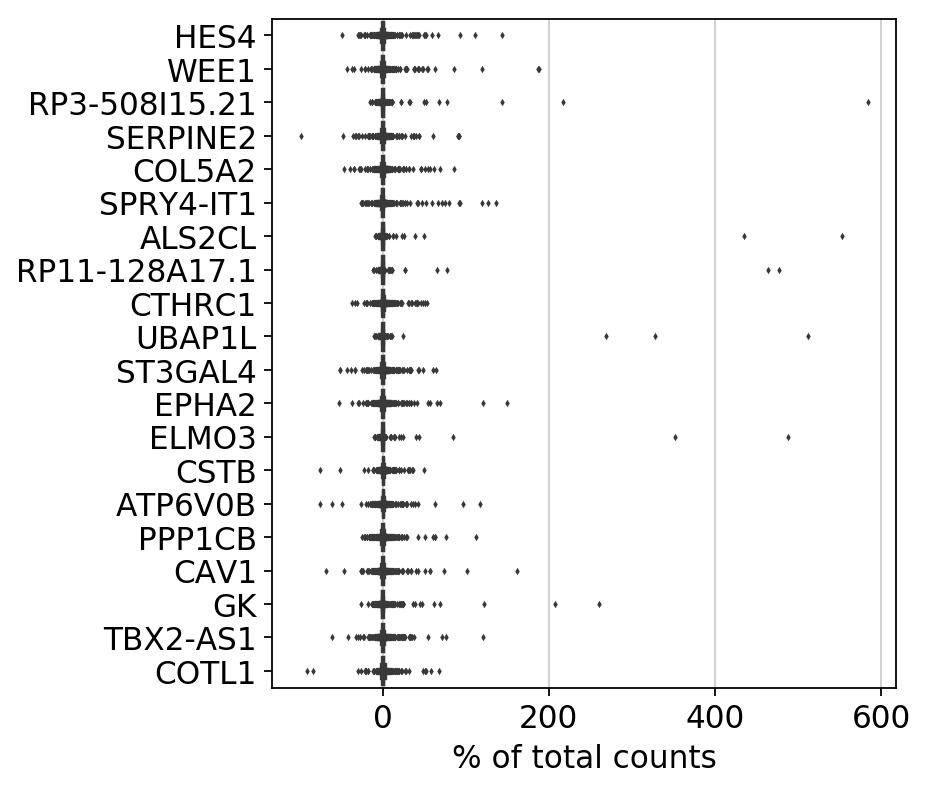

filtered out 1918 cells that have less than 1 counts


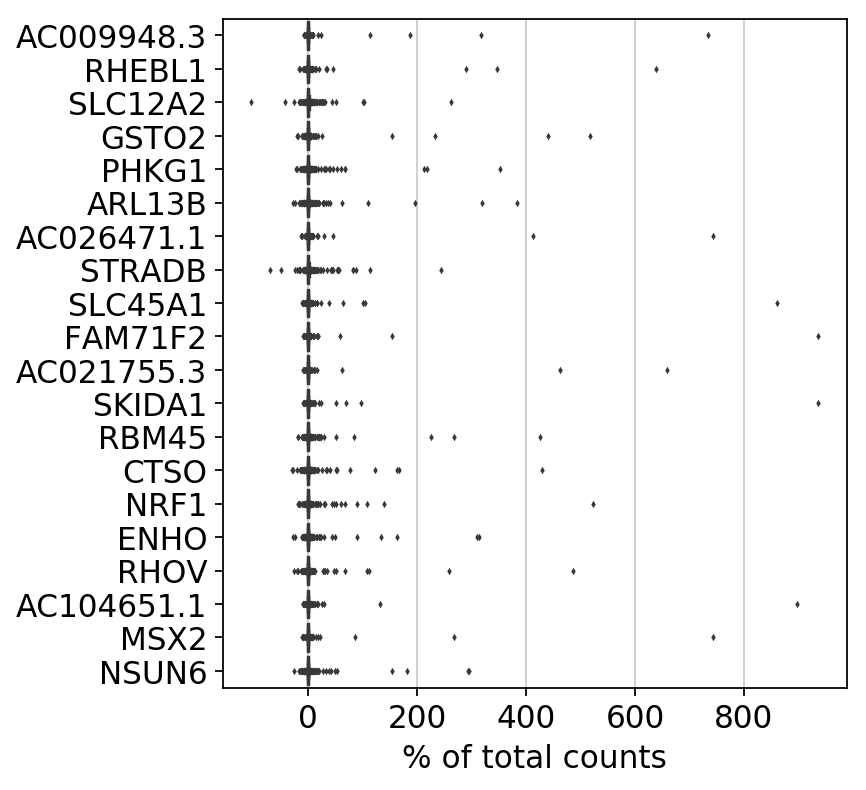

In [203]:
sc.pl.highest_expr_genes(ctrmat, n_top=20)
sc.pl.highest_expr_genes(v2mat, n_top=20)

Given that these genes are normalised, this plot is pretty much nonsense and no examination can be made.

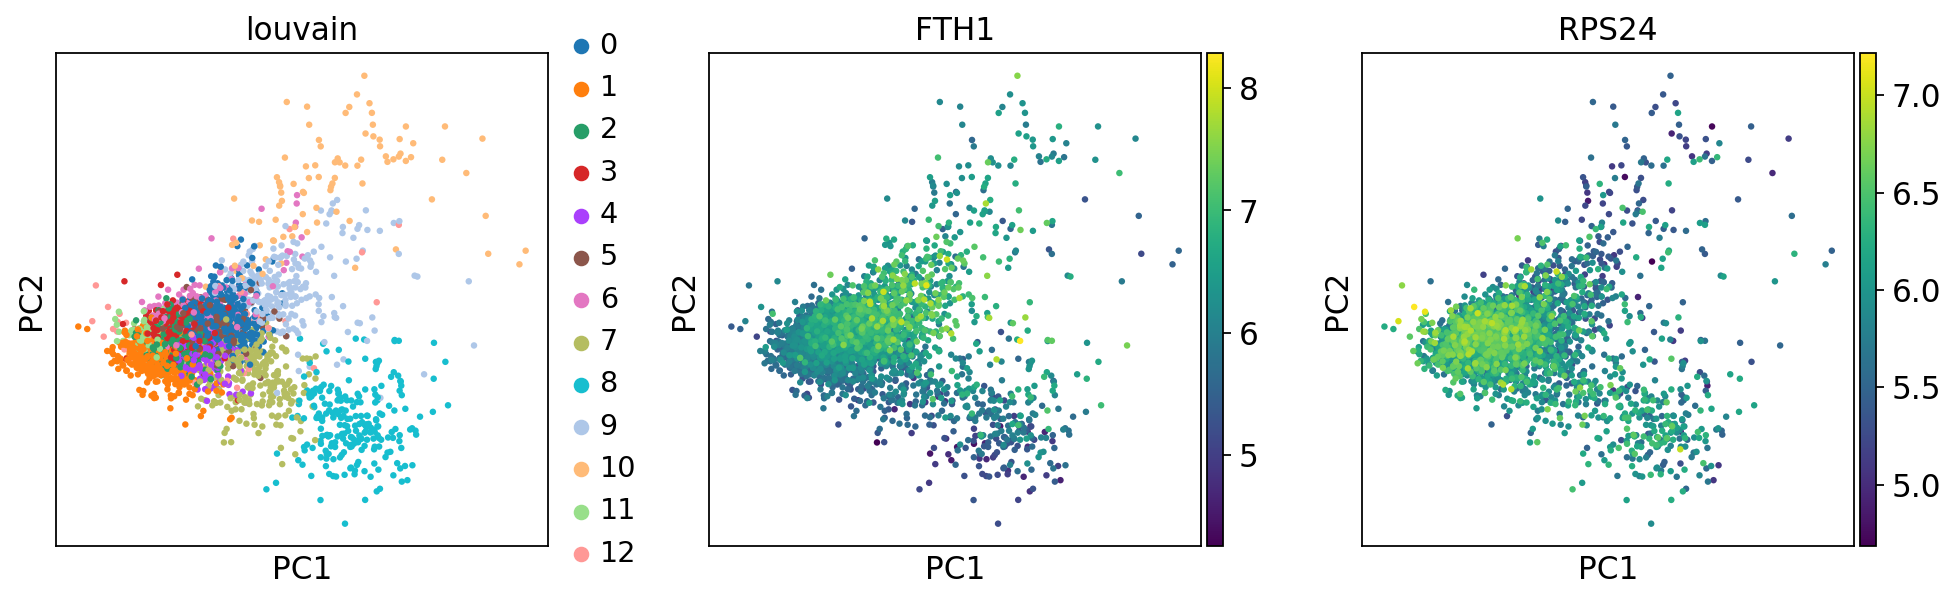

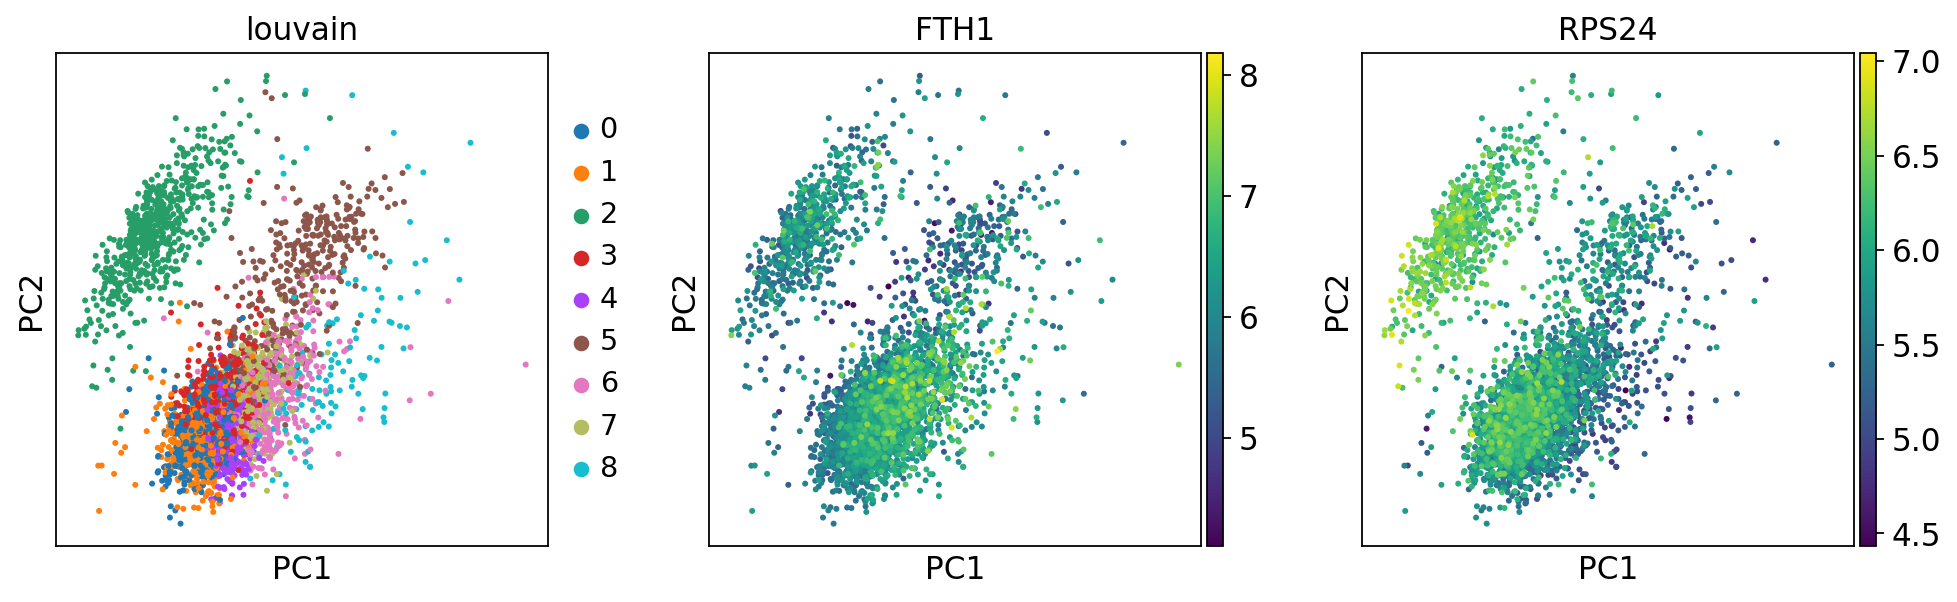

In [205]:
sc.pl.pca(ctrmat, color=['louvain', 'FTH1','RPS24'])
sc.pl.pca(v2mat, color=['louvain', 'FTH1','RPS24'])

Already we can see massive differences in the clustering, albeit mostly from the extra cluster in the V2 matrix, where otherwise they would be quite similar.

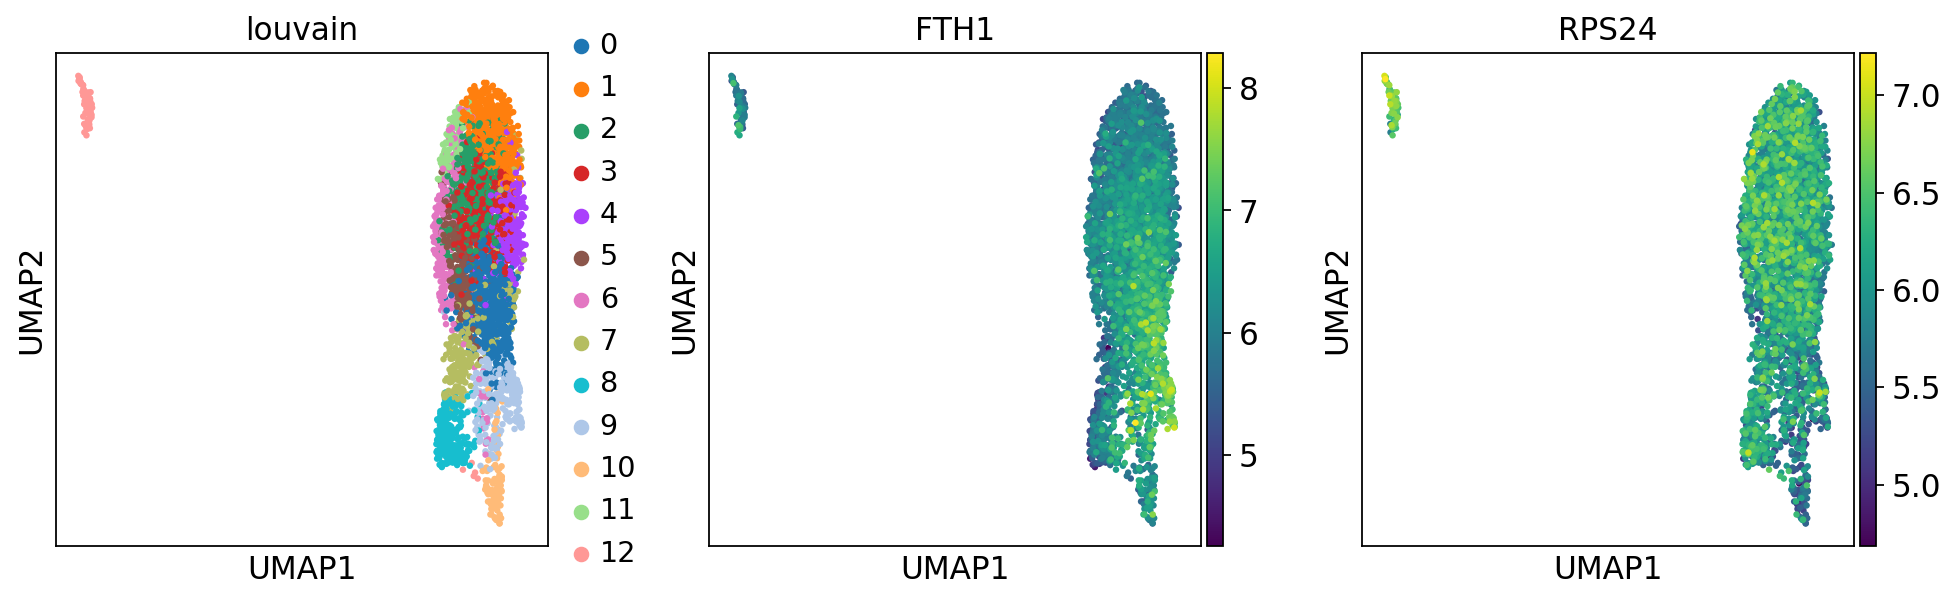

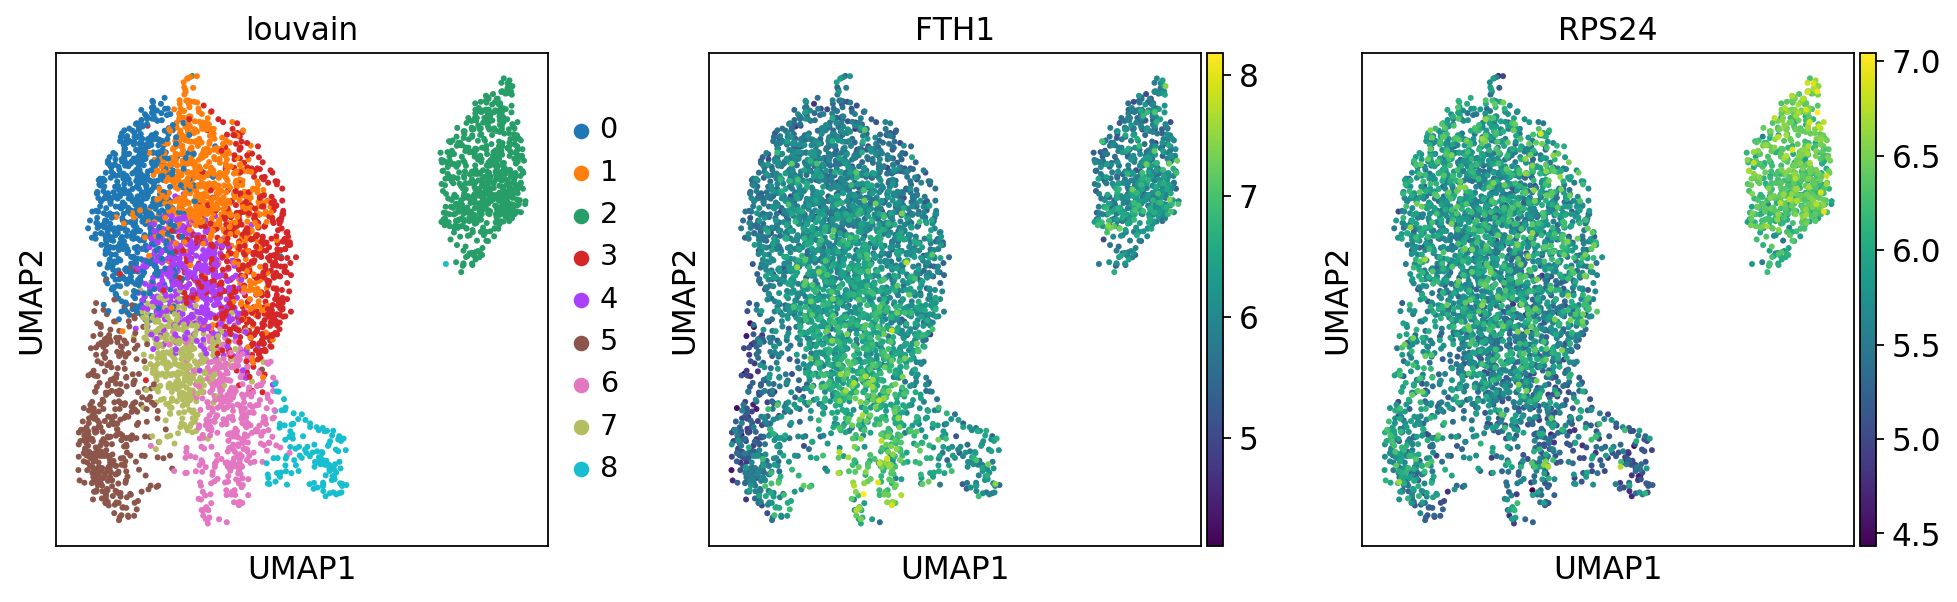

In [207]:
sc.pl.umap(ctrmat, color=['louvain', 'FTH1','RPS24'])
sc.pl.umap(v2mat, color=['louvain', 'FTH1','RPS24'])

Here we are seeing some similarities, which we can better quantify by looking at the topN genes in each cluster
 * Can we use batch effect correction to overlay these ontop of one another and see how good the clustering is?

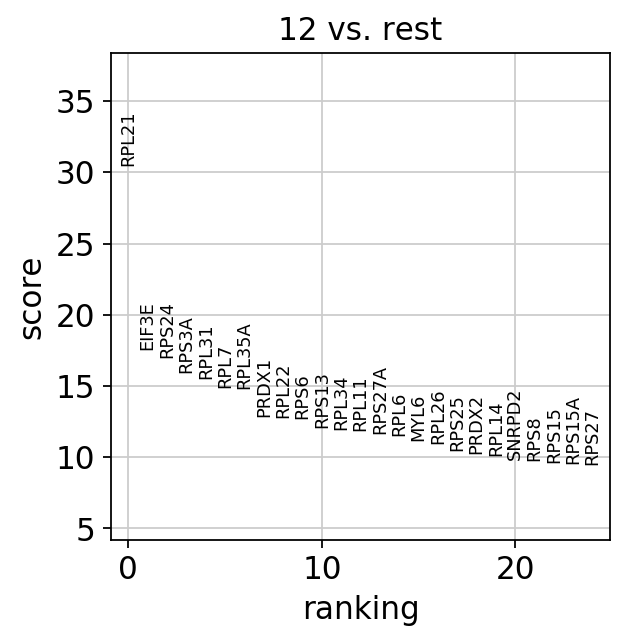

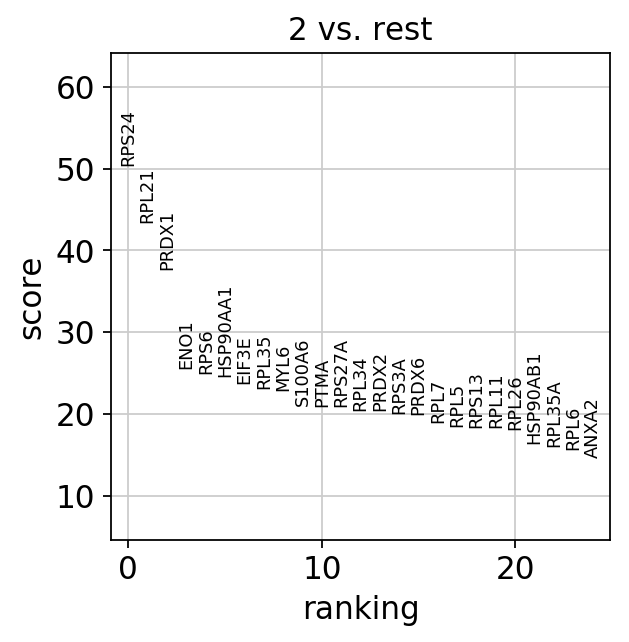

In [209]:
sc.pl.rank_genes_groups(ctrmat, n_genes=25, sharey=False, groups=['12'])
sc.pl.rank_genes_groups(v2mat, n_genes=25, sharey=False, groups=['2'])